In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA    
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV,LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.externals import joblib


filename = '../Data/LAT.csv'
filename1 = '../Data/LAT.csv'
filename2 = '../Data/CL_LAT.csv'

c:\program files\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


##### Function to generate a csv with parameterised correlation range

In [46]:
def cor_csv(filename, lower_cor, upper_cor ):
    df_data = pd.read_csv(filename, encoding='latin1')
    numerical_df = df_data.select_dtypes(exclude=['object'])
    corr_matrix = numerical_df.corr()
    #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
    sol_df = pd.DataFrame(data=sol)
    f_df = sol_df.reset_index().rename(columns = {'level_0':'Variable_1', 'level_1':'Variable_2', 0:'Correlation' })
    f_df[ (f_df['Correlation']>=upper_cor) | (f_df['Correlation']<= lower_cor)].to_csv('../Data/Cor_df.csv')


In [47]:
cor_csv(filename, -0.3, 0.3)

#### Function to generate a csv with parameterised correlation range

In [77]:
def cor_mrg_csv(filename1,filename2, lower_cor, upper_cor ):
    df_data1 = pd.read_csv(filename1, encoding='latin1')
    df_data2 = pd.read_csv(filename2, encoding='latin1')
    
    df_data = pd.merge(df_data1, df_data2, how='inner', on=['TIN','NPI']) # param join and condition
    #numerical_df = df_data.select_dtypes(exclude=['object'])
    corr_matrix = df_data.corr()
    #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
    sol_df = pd.DataFrame(data=sol)
    f_df = sol_df.reset_index().rename(columns = {'level_0':'Variable_1', 'level_1':'Variable_2', 0:'Correlation' })
    f_df[ (f_df['Correlation']>=upper_cor) | (f_df['Correlation']<= lower_cor)].to_csv('../Data/Cor_mrg_df.csv')


In [78]:
cor_mrg_csv(filename1,filename2, -0.3, 0.3)

#### Visualization function

In [98]:
def dist_plot(filename, col_list):
    df_data = pd.read_csv(filename1, encoding='latin1')    
    numerical_df = df_data.select_dtypes(exclude=['object'])
    
    #col_list = numerical_df.columns
    
    for i in col_list:
        fig, axes = plt.subplots(1,1, figsize=(10,6))
        dis_plot = sns.distplot(numerical_df[i])   #save image output
        d_plot = dis_plot.get_figure()
        pltpath = '../Output/Distplot/'
        d_plot.savefig(pltpath+i+'.png')

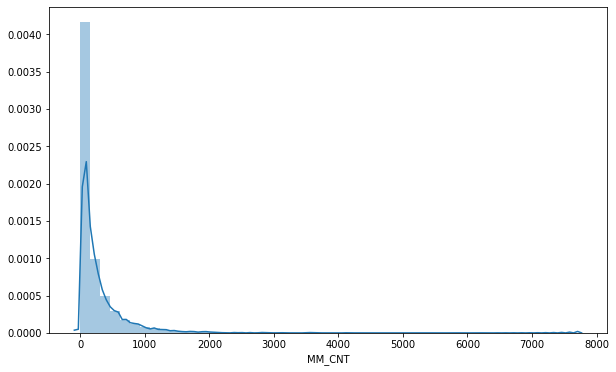

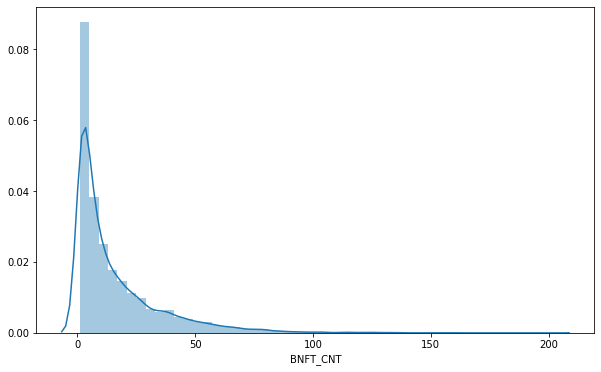

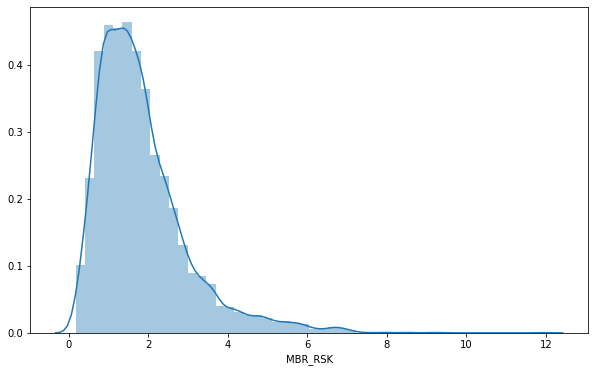

In [99]:
col_list = ['MM_CNT','BNFT_CNT','MBR_RSK']
dist_plot(filename,col_list)

##### Outlier removal from file based on z-score

In [68]:
def remove_outlier(filename, limit):
    df_data = pd.read_csv(filename1, encoding='latin1')
    numerical_df = df_data.select_dtypes(exclude=['object'])
    numerical_df[(np.abs(stats.zscore(numerical_df)) < limit).all(axis=1)].to_csv('../Data/clean_mrg_df.csv')
    numerical_df[(np.abs(stats.zscore(numerical_df)) > limit).all(axis=1)].to_csv('../Data/out_mrg_df.csv')

In [69]:
remove_outlier(filename, 3)

#### Outlier removal alternate

In [75]:
def drop_numerical_outliers(df, limit):
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < limit, reduce=False) \
        .all(axis=1)
    
    df.drop(df.index[~constrains], inplace=True)
    df.to_csv('../Data/cln_mrg_df.csv')

In [76]:
drop_numerical_outliers(df_data, 3)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions
  This is separate from the ipykernel package so we can avoid doing imports until


#### Plotting outliers in box-plot

In [1]:
def box_plot(filename, col_list):
    df_data = pd.read_csv(filename1, encoding='latin1')    
    numerical_df = df_data.select_dtypes(exclude=['object'])
    
    #col_list = numerical_df.columns
    
    for i in col_list:
        fig, axes = plt.subplots(1,1, figsize=(10,6))
        sns_plot = sns.boxplot(numerical_df[i])   #save image output
        s_plot = sns_plot.get_figure()
        pltpath = '../Output/Boxplot/'
        s_plot.savefig(pltpath+i+'.svg')

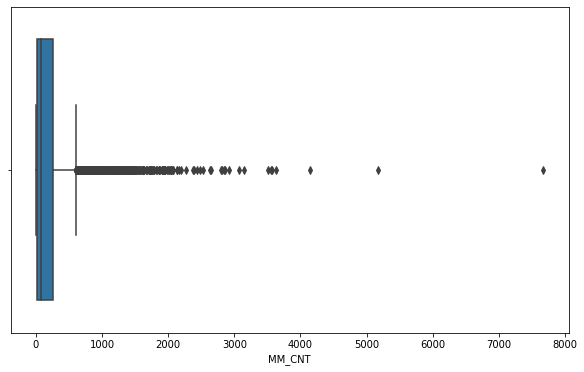

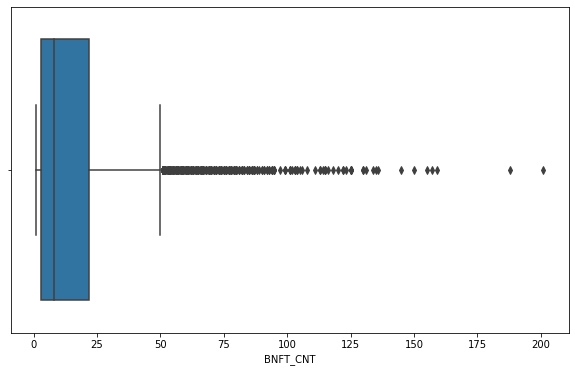

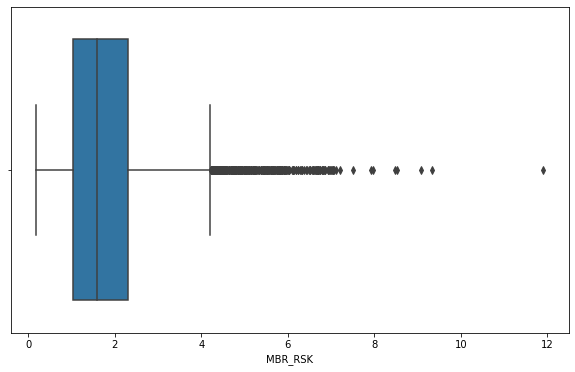

In [4]:
col_list = ['MM_CNT','BNFT_CNT','MBR_RSK']
box_plot(filename,col_list)

#### Drop columns where percent null values greater than threshold

In [106]:
def drop_null(filename, threshold):
    dfp = pd.read_csv(filename, encoding='latin1')
    na_data = dfp.isna().sum()[dfp.isna().sum()!=0]
    data_dict = {'column':na_data.index,
             'count':na_data.values , 
             'pct': np.round((na_data.values*100)/dfp.shape[0],2) 
            }

    init_data = pd.DataFrame(data=data_dict)
    drop_columns = init_data['column'][init_data['pct']>threshold]

    #Drop null columns
    dfp.drop(drop_columns, axis=1, inplace=True)
    dfp.to_csv('../Output/nadrop_df.csv')

In [107]:
drop_null(filename,80)

#### Fill missing values

In [120]:
def fill_null(filename, fill_type, fill_col):
    dfp = pd.read_csv(filename, encoding='latin1')

    #fill null values
    if fill_type== 'mean':
        for i in fill_col:
            dfp[i].fillna(dfp[i].mean(), inplace=True)
    
    elif fill_type=='median':
        for i in fill_col:
            dfp[i].fillna(dfp[i].median(), inplace=True)
            
    dfp.to_csv('../Output/nafill_df.csv')

In [122]:
fill_col = ['MM_CNT','BNFT_CNT','MBR_RSK']
fill_null(filename,'median',fill_col)

#### Clustering

- Elbow curve plot

In [6]:
############ Elbow curve plot to determine number of clusters#################

def elbow_num_cluster(filename, con_var, l_range, u_range, scale_ind):
    df = pd.read_csv(filename, encoding='latin1')
    df_con = df[con_var].copy()
    
    if scale_ind=='Y':
        scaler = StandardScaler()
        d_scale = scaler.fit_transform(df_con)
        df_scale = pd.DataFrame(d_scale, columns=con_var)
    
    else:
        df_scale = df_con.copy()
        
    
    wcss=[]
    for i in range (l_range, u_range):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df_scale)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(l_range, u_range), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Intertia')
    pltpath = '../Output/Elbow/'
    plt.savefig(pltpath+'elbow_plot.png')



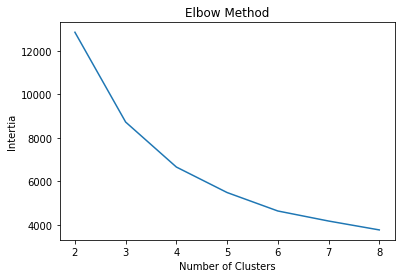

In [7]:
con_var =  ['MM_CNT','BNFT_CNT','MBR_RSK']
elbow_num_cluster(filename, con_var,2,9,'Y' )

In [12]:
def create_kmean_cluster(filename, con_var, num_clust):
    df = pd.read_csv(filename, encoding='latin1')
    
    df_cont = df[con_var].copy()
    
    imputer = Imputer(strategy='mean')
    d_imp = imputer.fit_transform(df_cont)
    df_imp = pd.DataFrame(d_imp, columns=con_var)
    
    scaler = StandardScaler()
    d_scale = scaler.fit_transform(df_imp)
    df_scale = pd.DataFrame(d_scale, columns=con_var)
    
    kmeans = KMeans(n_clusters=num_clust, init='k-means++', max_iter=300, n_init=10, random_state=0)
    df_k = kmeans.fit_predict(df_scale)
    df['Cluster'] = df_k
    df.to_csv('../Output/kmeans.csv')
    
    # Calculating performace of the clusters using Silhoutte score
    avg_sil_score = silhouette_score(df_scale, df_k)
    sil_sample_score= silhouette_samples(df_scale, df_k)
    print(avg_sil_score)
    #print(sil_sample_score)
    
    
    

In [11]:
create_kmean_cluster(filename, con_var, 4)

c:\program files\python36\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


0.456679722975872
[ 0.67023429  0.41956045  0.5025934  ...  0.25998192  0.30779312
 -0.02018262]


 - Dimentionality Reduction

In [20]:
def pca_plot(dim, filename,con_var):
    
    df = pd.read_csv(filename, encoding='latin1')
    df_cont = df[con_var].copy()
    
    imputer = Imputer(strategy='mean')
    d_imp = imputer.fit_transform(df_cont)
    df_imp = pd.DataFrame(d_imp, columns=con_var)
    
    scaler = StandardScaler()
    d_scale = scaler.fit_transform(df_imp)
    df_scale = pd.DataFrame(d_scale, columns=con_var)
    
    pca = PCA(dim)
    pca_ftr = pca.fit_transform(df_scale)
    df_pca_ftr = pd.DataFrame(pca_ftr, columns=con_var)
    df_pca_ftr.to_csv('../Output/dim_red_df.csv')
    
    num_cmpnt=len(pca.explained_variance_ratio_)
    ind = np.arange(num_cmpnt)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_cmpnt):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=10)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    pltpath = '../Output/PCA/'
    plt.savefig(pltpath+'pca_plot.png')



c:\program files\python36\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


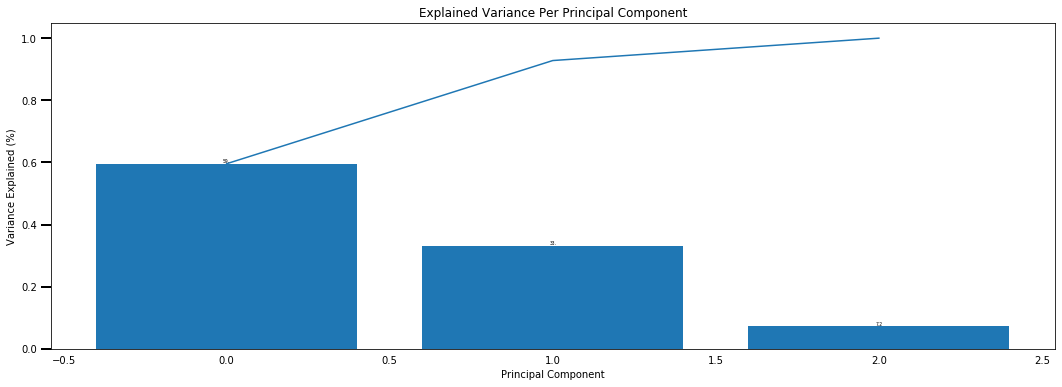

In [21]:
pca_plot(3,filename,con_var)

##### Linear Regression

In [28]:
def regression_func(filename, feature_list, label, reg_algo):
    df = pd.read_csv(filename, encoding='latin1')
    
    X = df[feature_list].copy()
    y = df[label].copy()
    
    r2score = []
    rmsescore = []
    
    if reg_algo == 'linear_regression':
        reg = LinearRegression()     
    
        cv = KFold(n_splits=5, random_state=40, shuffle=True)
        for train_index, test_index in cv.split(X):

            X_train, X_test, y_train, y_test = X.loc[train_index,:], X.loc[test_index,:], y.loc[train_index,:], y.loc[test_index,:]
        
            reg.fit(X_train,y_train)
            y_pred = reg.predict(X_test)
        
            rmsescore.append(mean_squared_error(y_test, y_pred))
            r2score.append(r2_score(y_test, y_pred))
                    
        result_dict = {'Test Mean Squared Error' : np.mean(rmsescore),
                        'Test R2 Score' : np.mean(r2score)}
        
    elif reg_algo == 'RandomForestRegressor':
        reg = RandomForestRegressor(random_state=40)     
    
        cv = KFold(n_splits=5, random_state=40, shuffle=True)
        for train_index, test_index in cv.split(X):

            X_train, X_test, y_train, y_test = X.loc[train_index,:], X.loc[test_index,:], y.loc[train_index,:], y.loc[test_index,:]
        
            reg.fit(X_train,y_train)
            y_pred = reg.predict(X_test)
        
            rmsescore.append(mean_squared_error(y_test, y_pred))
            r2score.append(r2_score(y_test, y_pred))
                    
        result_dict = {'Test Mean Squared Error' : np.mean(rmsescore),
                        'Test R2 Score' : np.mean(r2score)}
        
    m_filename = '../Output/reg_model.sav'
    joblib.dump(reg, m_filename)
    return result_dict 
        
        
    

In [34]:
feature_list = ['MM_CNT','BNFT_CNT']
label = ['MBR_RSK']
reg_perf = regression_func(filename,feature_list,label, 'linear_regression' )
#regression_func(filename,feature_list,label, 'RandomForestRegressor' )

In [39]:
reg_perf['Test Mean Squared Error']

1.3003992610247657

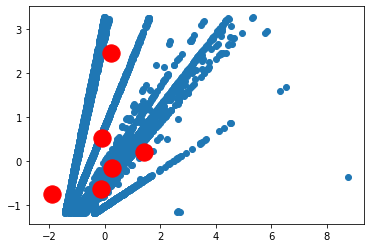

In [185]:
kmeans = KMeans(n_clusters=6,init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit_predict(df_scale)
plt.scatter(df_scale['MBR_RSK'],df_scale['SSAV_PMPM'])
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='red')
plt.show()
    

In [180]:
df_imp

array([[1.830e+00, 1.020e+00, 1.280e+00, 9.600e+01],
       [1.830e+00, 1.830e+00, 2.290e+00, 2.810e+02],
       [1.840e+00, 2.040e+00, 2.550e+00, 1.500e+01],
       ...,
       [1.650e+00, 2.380e+00, 3.880e+00, 1.629e+03],
       [1.650e+00, 2.090e+00, 2.350e+00, 1.790e+02],
       [1.660e+00, 2.460e+00, 2.760e+00, 1.010e+02]])

In [152]:
df_p = kmeans.fit_predict(df_c)

In [167]:
df_c['Cluster']= df_p

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [157]:
df_c.head()

,MBR_RSK,MRKT_RSK,Cluster
0,1.02,1.83,0
1,1.83,1.83,2
2,2.04,1.84,2
3,0.91,1.83,0
4,1.11,1.83,0
